In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import time
import planarity
from networkx.algorithms import community
import collections
import os

In [2]:
file_name = os.listdir('graph_info')


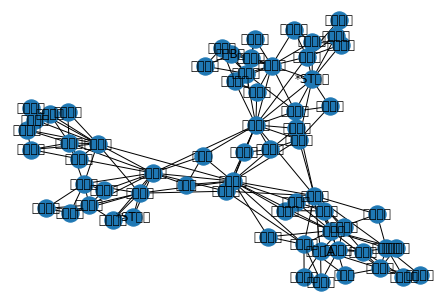

In [3]:
pmfg = nx.read_gpickle(f'graph_info/{file_name[0]}')
nx.draw(pmfg,with_labels=True)

In [4]:
pmfg.remove_node('海通证券')
# pmfg.nodes

64

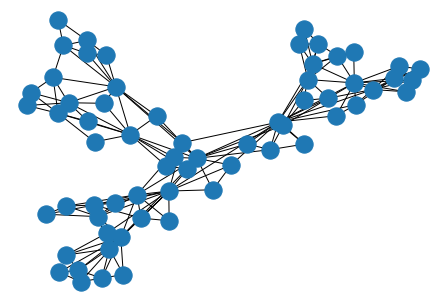

In [5]:
nx.draw(pmfg)
pmfg.nodes
len(max(nx.connected_components(pmfg)))

In [6]:
# 按照不同行业排序（degree）
# pmfg.degree()存起来，再和子行业一一对应，获取其前n个节点
# remove_node()看看什么时候巨片开始崩塌
# 存数据
# 画图


# 数据： 行：月份+子行业，列：排序，内容：节点名称
# remove_nodes 每一列下来按照顺序移除节点。

In [13]:


all_result = []
# for i in range(len(file_name)):
for i in range(10):
    pmfg = nx.read_gpickle(f'graph_info/{file_name[i]}')
    degree_dict = dict(pmfg.degree())
    list1= sorted(dict(pmfg.degree()).items(),key=lambda x:x[1],reverse=True)
    # list1= sorted(degree_dict.keys(),reverse=True)
    degree_dict = [k for k,v in list1]
    # print(degree_dict)
    degree_df = pd.DataFrame(degree_dict,columns=[f'{file_name[i][:-8]}'])
    ccp_list = []
    for j in range(len(degree_df)-1):
        # print(degree_df.iloc[j].values[0])
        # print(type(pmfg))
        # print(pmfg.nodes)
        pmfg.remove_node(degree_df.iloc[j].values[0])
        size_of_ccp = len(max(nx.connected_components(pmfg)))
        ccp_list.append(size_of_ccp)
    all_result.append(ccp_list)




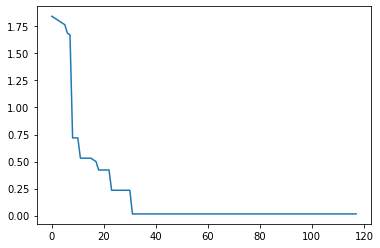

In [16]:
plt.plot(np.array(all_result[9])/max(all_result[0]))

In [77]:
degree_df = pd.DataFrame(degree_dict,columns=[f'{file_name[0][:-8]}'])
degree_df

,2011-06
0,华泰证券
1,中国人寿
2,兴业银行
3,海通证券
4,国网英大
...,...
60,哈投股份
61,锦龙股份
62,西部资源
63,爱建集团


In [78]:
pmfg.remove_node(degree_df.iloc[0].values[0])

In [80]:
largest_components=max(nx.connected_components(pmfg),key=len)  # 高效找出最大的联通成分，其实就是sorted里面的No.1
nx.draw(largest_components)

AttributeError: 'set' object has no attribute 'edges'

In [65]:
len(largest_components)

64

In [83]:
import random
from scipy.special import binom
from scipy.integrate import solve_ivp
def S_r(g, method):
    
    N = g.number_of_nodes() 
    if method == 'rand':
        deg_seq = g.degree
        deg_seq = random.sample(list(deg_seq),len(deg_seq)) # node adding order = random shuffle 
    elif method == 'deg':
        deg_seq = g.degree
        deg_seq = sorted(deg_seq, key=lambda seq: seq[1]) # node adding order = sort by deg
    elif method == 'btw':
        btwness = nx.betweenness_centrality(g) 
        deg_seq = sorted(btwness.items(), key=lambda seq: seq[1]) # node adding order = sort by betweenness

    names = [name for name,degree in list(deg_seq)]
    transfer_dic = {}
    for i,j in enumerate(names):
        transfer_dic[j]=i
    ctl = N*[0] # cluster list
    Sr = [1]*(N+1) # biggest cluster size
    for i,j in enumerate(deg_seq):
        ctl[transfer_dic[j[0]]] = i+1
        Sr[i+1] = Sr[i]
        if list(g.neighbors(j[0])) != []:
            for k in list(g.neighbors(j[0])):
                if ctl[transfer_dic[k]]>0:
                    ctl = [np.minimum(ctl[transfer_dic[k]],ctl[transfer_dic[j[0]]]) if (x == ctl[transfer_dic[k]] or x == ctl[transfer_dic[j[0]]]) else x for x in ctl]
            Sr_new = ctl.count(ctl[transfer_dic[j[0]]])
            if Sr_new > Sr[i]:
                Sr[i+1] = Sr_new
    return Sr


def S_phi(phi,g, method='rand'): 
    Sr = S_r(g,method)
    S = [0]*len(phi)
    for i,phii in enumerate(phi):
        sum = 0
        for r in range(len(Sr)):
            sum += binom(len(Sr)-1,r)*phii**r*(1-phii)**(len(Sr)-1-r)*Sr[r]
        S[i] = sum
    return S

In [82]:
# The code can take a long time
temp = nx.Graph(pmfg)
N = 105
trials = 10

phi = np.linspace(0,1,N)

S_rand = np.zeros(N)

S_trial = np.zeros((trials,N))
for t in range(trials):
    S_trial[t] = S_phi(phi,temp,'rand') 
S_rand = np.mean(S_trial,0)

S_deg = np.zeros(N)
S_trial = np.zeros((trials,N))
for t in range(trials):
    S_trial[t] = S_r(temp,'deg')[1:] 
S_deg = np.mean(S_trial,0)    

plt.figure(figsize=(22,8))
fig, ax = plt.subplots(1, 2, figsize=(10,4))
# fig.suptitle('Size of giant component in Political Book network',fontsize=16,y=1.05)


ax[0].plot(phi,S_rand, 'o', mfc='none', ms=3, )
ax[1].plot(phi,S_deg, 'o', mfc='none', ms=3, )

ax[0].set_title("Random removal")    
ax[1].set_title("Removal in degree order")    
ax[0].set_ylabel('S')
for a in ax:
    a.set_xlabel(r"$\phi$")
    
# plt.savefig('/Users/dongzhang/Desktop/attack.png')
plt.show()
    

ValueError: cannot copy sequence with size 63 to array axis with dimension 105